# Recommender System - Neural Network

The recommender here use the RMSE loss function.

## 1. Prerequisites

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings


warnings.filterwarnings('ignore')
%matplotlib inline


import scipy
import scipy.io
import scipy.sparse as sp

from sklearn.preprocessing import LabelEncoder


%load_ext autoreload
%autoreload 2

In [6]:
from helpersNeuralNet import load_data
from sklearn.model_selection import train_test_split

DATA_TRAIN_PATH = "data/data_train.csv"
ratings = load_data(DATA_TRAIN_PATH)

DATA_TEST_PATH = "data/sampleSubmission.csv"
samples = load_data(DATA_TEST_PATH)

n_users = len(ratings.user_id.unique())
n_books = len(ratings.movie_id.unique())

train, test = train_test_split(ratings, test_size=0.1, random_state=42)

Using TensorFlow backend.


In [7]:
samples.head()

,user_id,movie_id,rating
0,37,1,3
1,73,1,3
2,156,1,3
3,160,1,3
4,248,1,3


## 2. Data preprocessing

In [8]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['user_id'].values)
n_users = ratings['user'].nunique()

item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movie_id'].values)
n_movies = ratings['movie'].nunique()

ratings['rating'] = ratings['rating'].values.astype(np.int)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

In [44]:
X = ratings[['user', 'movie']].values
y = ratings['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [45]:
n_factors = 25

X_train_array = [X_train[:,0], X_train[:,1]]
X_test_array = [X_test[:,0], X_test[:,1]]

## 3. Neural network

In [46]:
from keras.layers import Add, Activation, Lambda
from keras.layers import Concatenate, Dense, Dropout, Input, Reshape, Dot
from keras.models import Model,load_model
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
from keras_radam import RAdam

class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-5))(x)
        x = Reshape((self.n_factors,))(x)
        return x
    
    
def RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating):
    
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    
    model = Model(inputs=[user, movie], outputs=x)
    model.compile(loss='mean_squared_error', optimizer=RAdam(), metrics=['mse', 'accuracy'])
#     opt = Adam(lr=0.001)
    
    return model

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_27 (Embedding)        (None, 1, 25)        250000      input_27[0][0]                   
__________________________________________________________________________________________________
embedding_28 (Embedding)        (None, 1, 25)        25000       input_28[0][0]                   
___________________________________________________________________________________________

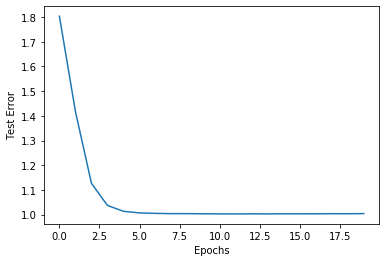

In [48]:
model = RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating)
model.summary()

if os.path.exists('NeuralNet_base.h5'):
    model = load_model('NeuralNet_base.h5')
else:
    history = model.fit(x=X_train_array, y=y_train,  batch_size=10000, epochs=20, verbose=1, validation_data=(X_test_array, y_test))
    model.save('NeuralNet_base.h5')
    plt.plot(history.history['val_loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Test Error")

### 5.2 Model validation

In [49]:
from sklearn.metrics import mean_squared_error

prediction_test = np.array([a[0] for a in model.predict(x=X_test_array)])

print (mean_squared_error(y_test, prediction_test))

0.9997292606535696


## 6. Building real test data

In [50]:
user_enc = LabelEncoder()
samples['user'] = user_enc.fit_transform(samples['user_id'].values)
n_users = samples['user'].nunique()

item_enc = LabelEncoder()
samples['movie'] = item_enc.fit_transform(samples['movie_id'].values)
n_movies = samples['movie'].nunique()

samples['rating'] = samples['rating'].values.astype(np.int)

X = samples[['user', 'movie']].values
X_array = [X[:,0], X[:,1]]

prediction = np.array([a[0] for a in model.predict(x=X_array)])

samples.drop('rating',axis = 1, inplace = True)
samples['rating'] = prediction

In [52]:
from helpersNeuralNet import create_csv

DATA_SUBMISSION = "data/submission_neuralnet_base.csv"
create_csv(DATA_SUBMISSION, samples)

AICrowd result : RMSE = 1.159 : Secondary = -0.056